# <a id='env'>2. Setting up the Environment</a>

In [15]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [16]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [17]:
!pip install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN\YES TRAIN\NO TEST\YES TEST\NO VAL\YES VAL\NO
!tree -d

A subdirectory or file TRAIN already exists.
Error occurred while processing: TRAIN.
A subdirectory or file TEST already exists.
Error occurred while processing: TEST.
A subdirectory or file VAL already exists.
Error occurred while processing: VAL.
A subdirectory or file TRAIN\YES already exists.
Error occurred while processing: TRAIN\YES.
A subdirectory or file TRAIN\NO already exists.
Error occurred while processing: TRAIN\NO.
A subdirectory or file TEST\YES already exists.
Error occurred while processing: TEST\YES.
A subdirectory or file TEST\NO already exists.
Error occurred while processing: TEST\NO.
A subdirectory or file VAL\YES already exists.
Error occurred while processing: VAL\YES.
A subdirectory or file VAL\NO already exists.
Error occurred while processing: VAL\NO.
'tree' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
IMG_PATH = 'Brain Tumor/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>3. Data Import and Preprocessing</a>

In [22]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]

50 images loaded from VAL/ directory.


Let's take a look at the distribution of classes among sets:

In [24]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [25]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

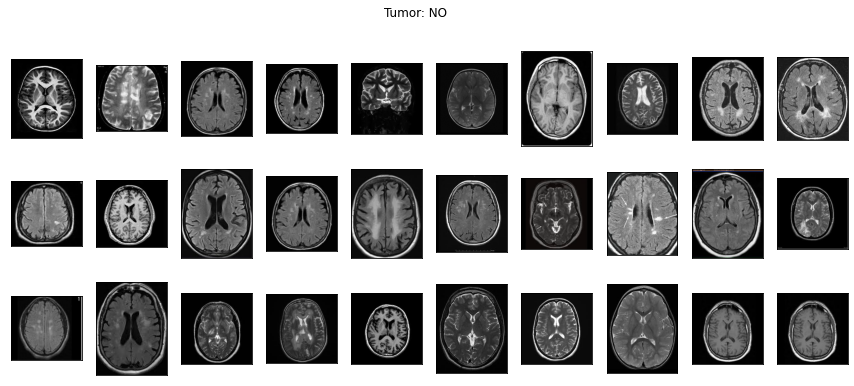

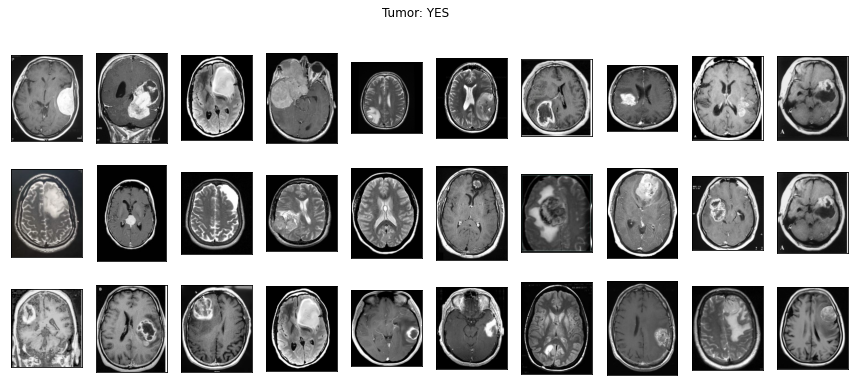

In [26]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

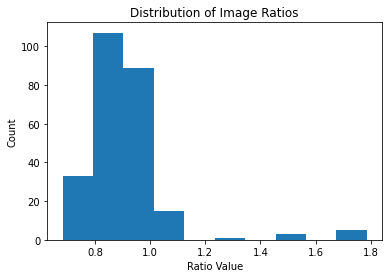

In [27]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [28]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [30]:
img = cv2.imread('Brain Tumor/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

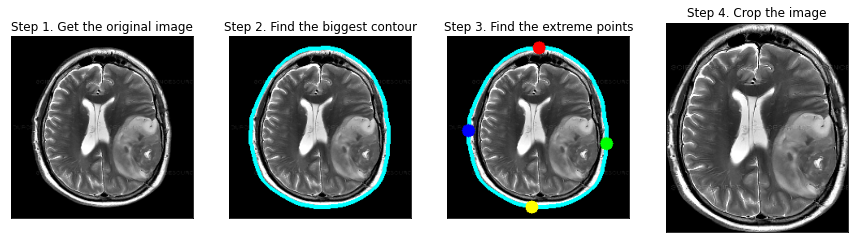

In [31]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [32]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

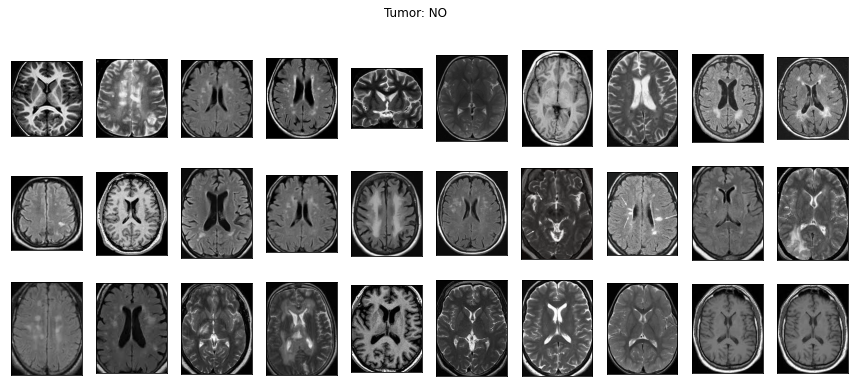

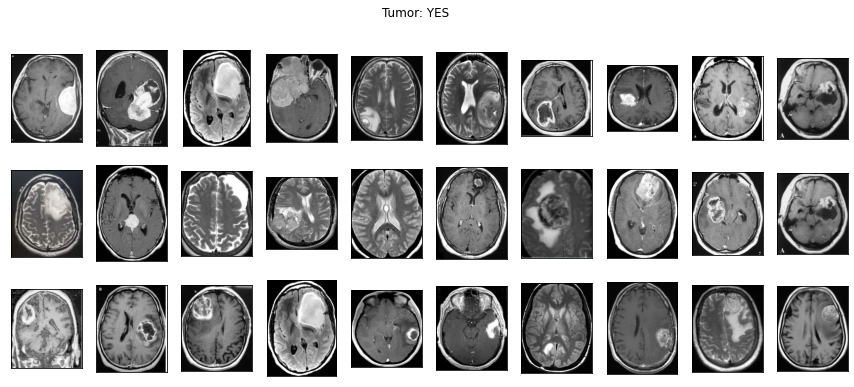

In [33]:
plot_samples(X_train_crop, y_train, labels, 30)

In [34]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [35]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP\YES TRAIN_CROP\NO TEST_CROP\YES TEST_CROP\NO VAL_CROP\YES VAL_CROP\NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [36]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [37]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [38]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [39]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [40]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

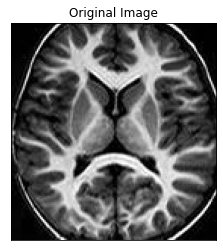

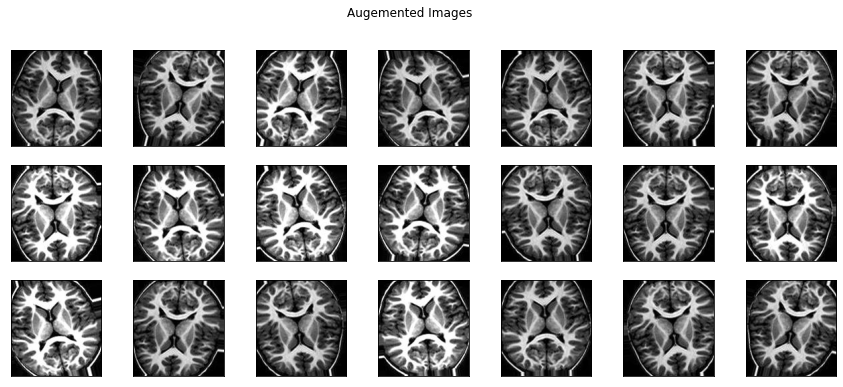

In [41]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [42]:
!rd /s /q "preview/"

### <a id='apply'>4.1.2. Apply</a>

In [43]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [28]:
# load base model
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [29]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size,
    callbacks=[es]
)

Epoch 1/30
6/6 [==============================] - 43s 7s/step - loss: 3.9662 - accuracy: 0.6646 - val_loss: 2.1027 - val_accuracy: 0.6667
Epoch 2/30
6/6 [==============================] - 48s 8s/step - loss: 5.1214 - accuracy: 0.5885 - val_loss: 1.6151 - val_accuracy: 0.7083
Epoch 3/30
6/6 [==============================] - 41s 7s/step - loss: 4.4784 - accuracy: 0.6087 - val_loss: 1.4361 - val_accuracy: 0.6667
Epoch 4/30
6/6 [==============================] - 42s 7s/step - loss: 3.7081 - accuracy: 0.5839 - val_loss: 1.4923 - val_accuracy: 0.7292
Epoch 5/30
6/6 [==============================] - 42s 7s/step - loss: 3.9936 - accuracy: 0.6335 - val_loss: 1.0356 - val_accuracy: 0.7292
Epoch 6/30
6/6 [==============================] - 49s 8s/step - loss: 3.8530 - accuracy: 0.6460 - val_loss: 0.9367 - val_accuracy: 0.7708
Epoch 7/30
6/6 [==============================] - 49s 8s/step - loss: 4.5262 - accuracy: 0.5901 - val_loss: 0.9316 - val_accuracy: 0.7500
Epoch 8/30
6/6 [==================

## <a id='perf'>4.3. Model Performance</a>

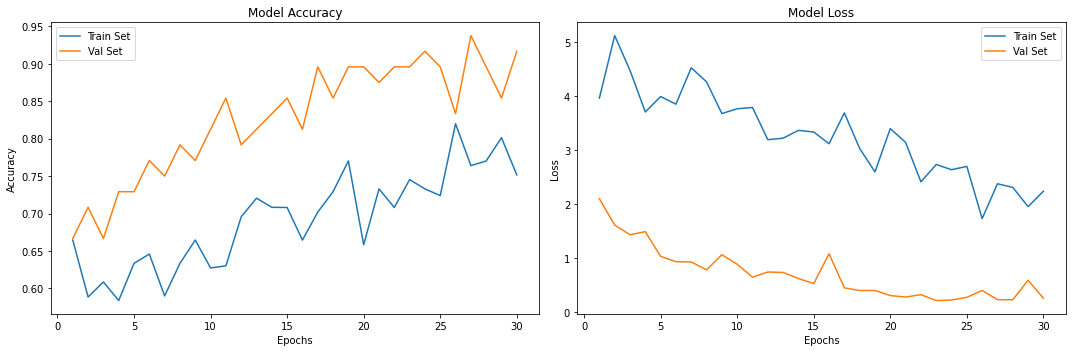

In [34]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.94


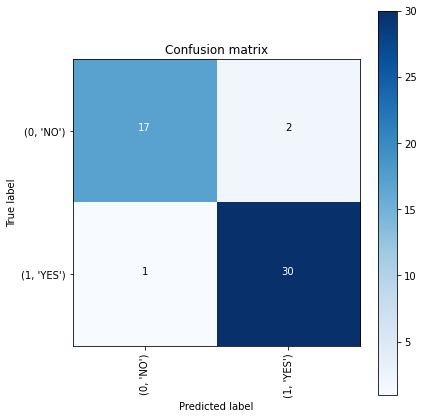

In [35]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.70


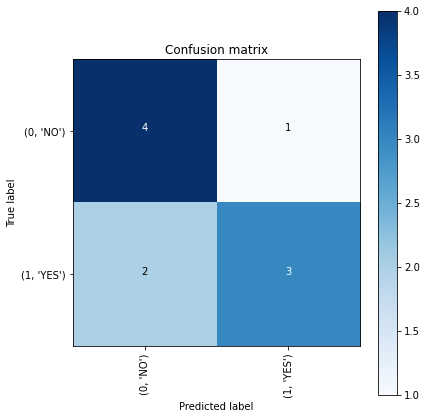

In [36]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

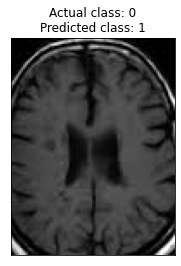

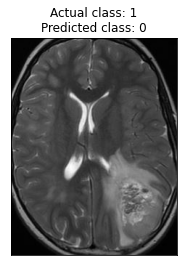

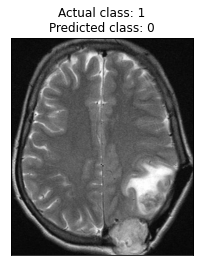

In [38]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [39]:
# # clean up the space
# !rd /s /q TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# # save the model
# model.save('2019-06-07_VGG_model.h5')

# Applying Simple CNN

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback

In [79]:
model = Sequential()

#1-conv layer
model.add(Conv2D(64, (3,3), padding = 'same', input_shape=(224, 224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


#2-conv layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


#3-conv layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#4conv layer
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Flatten
model.add(Flatten())


model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


#output layer
model.add(Dense(1,activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_68 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
activation_68 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 112, 112, 128)     204928    
_________________________________________________________________
batch_normalization_69 (Batc (None, 112, 112, 128)   

In [ ]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size


checkpoint = ModelCheckpoint("model_weights.h5",monitor="val_accuracy",
                            save_weights_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001, model='auto')


callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    #callbacks = callbacks
)

Epoch 1/30
6/6 [==============================] - 50s 8s/step - loss: 5.9671 - accuracy: 0.6087 - val_loss: 5.4008 - val_accuracy: 0.6458
Epoch 2/30
6/6 [==============================] - 60s 10s/step - loss: 5.7979 - accuracy: 0.6198 - val_loss: 5.4008 - val_accuracy: 0.6458
Epoch 3/30
6/6 [==============================] - 61s 10s/step - loss: 5.9671 - accuracy: 0.6087 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 4/30
6/6 [==============================] - 49s 8s/step - loss: 6.2512 - accuracy: 0.5901 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 5/30
6/6 [==============================] - 60s 10s/step - loss: 5.7979 - accuracy: 0.6198 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 6/30
6/6 [==============================] - 60s 10s/step - loss: 5.6829 - accuracy: 0.6273 - val_loss: 5.7185 - val_accuracy: 0.6250
Epoch 7/30
6/6 [==============================] - 59s 10s/step - loss: 5.7777 - accuracy: 0.6211 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 8/30
6/6 [=============

# Applying Resnet50

In [85]:
from keras import applications
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [87]:
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (224,224,3))

In [89]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(1, activation= 'softmax')(x)
resnetmodel = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
resnetmodel.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = resnetmodel.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size,
    #callbacks=[es]
)

Epoch 1/30
6/6 [==============================] - 91s 15s/step - loss: 5.9671 - accuracy: 0.6087 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 2/30
6/6 [==============================] - 83s 14s/step - loss: 6.1565 - accuracy: 0.5963 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 3/30
6/6 [==============================] - 83s 14s/step - loss: 5.5882 - accuracy: 0.6335 - val_loss: 5.7185 - val_accuracy: 0.6250
Epoch 4/30
6/6 [==============================] - 102s 17s/step - loss: 5.8724 - accuracy: 0.6149 - val_loss: 5.7185 - val_accuracy: 0.6250
Epoch 5/30
6/6 [==============================] - 83s 14s/step - loss: 5.2094 - accuracy: 0.6584 - val_loss: 5.7185 - val_accuracy: 0.6250
Epoch 6/30
6/6 [==============================] - 102s 17s/step - loss: 5.8724 - accuracy: 0.6149 - val_loss: 6.0362 - val_accuracy: 0.6042
Epoch 7/30
6/6 [==============================] - 1526s 254s/step - loss: 5.7777 - accuracy: 0.6211 - val_loss: 5.7185 - val_accuracy: 0.6250
Epoch 8/30
6/6 [======